In [480]:
import numpy as np
import numpy.matlib
import pandas as pd
import scipy.io as spio
from scipy import linalg
from scipy.stats import multivariate_normal as mvn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.cluster import KMeans
from PIL import Image

In [481]:
#load data - used code from previous assignment for this section
data = spio.loadmat('data.mat',squeeze_me=True)['data']
print(data.shape)
print(type(data))
data = data.T
#print(data.shape)
#print(type(data))
m,n = data.shape
print(m,n)

(784, 1990)
<class 'numpy.ndarray'>
1990 784


In [482]:
#Load Labels - used code from previous assignment for this section
trueLabel = spio.loadmat('label.mat', squeeze_me=True)['trueLabel']
#print(trueLabel.shape)
trueLabel[trueLabel==6] = 0
trueLabel[trueLabel==2] = 1

## Question 2.b

## PCA

In [483]:
#source demo code
# pca the data
C = np.matmul(data.T, data)/m

d = 4  # reduced dimension
V,Gamma,_ = np.linalg.svd(C)
V = V[:, :d]
Gamma = np.diag(Gamma[:d])

# project the data to the top 4 principal directions
# y = label
pdata = np.dot(data,V)
print(pdata.shape)
print(pdata)

(1990, 4)
[[-5.78589802 -1.86149301 -0.32208024 -4.02489803]
 [-6.05737029 -2.32665249  0.02495306  2.19068824]
 [-4.48984179 -1.25620196  0.57603288 -2.1753182 ]
 ...
 [-5.01432062  0.05119609 -3.140957    0.34626446]
 [-9.68151301  2.11536692 -3.89177429 -1.35164814]
 [-9.86028409  3.52677095 -1.11889327  0.62470281]]


In [484]:
#PCA_reconstruction = 

In [485]:
## PCA Data
pca = PCA(n_components=4)
pca.fit(data)
pdata2 = pca.transform(data)
pdata2[0]

m, n = pdata2.shape
print(m,n)
print(pdata2)

1990 4
[[-2.08266666e+00 -3.66224540e+00 -2.50045898e-03  1.49985287e+00]
 [-2.30974133e+00  1.43478979e+00 -1.21325964e-01 -2.12614610e+00]
 [-1.56985434e+00 -2.72947245e+00  7.80535448e-01 -9.08916586e-02]
 ...
 [-1.74816489e-01 -1.20991508e+00 -3.10161559e+00 -2.17713880e+00]
 [ 2.45925339e+00 -3.39528989e-02 -3.83631973e+00  2.44996631e+00]
 [ 3.99730500e+00  2.04604405e+00 -1.23337365e+00  2.12530265e+00]]


## Initialization

In [486]:
#source demo code
# number of mixtures
K = 2

# random seed
seed = 4

# initialize prior
# np.random.seed(seed)
pi = np.random.random(K)
pi = pi/np.sum(pi)
#print(pi)

# initial mean and covariance
# np.random.seed(seed)
mu = np.random.randn(K,d)
mu_old = mu.copy()
print(mu)

sigma = []
for ii in range(K):
    # to ensure the covariance psd
    # np.random.seed(seed)
    dummy = np.random.randn(d, d)
    sigma.append(dummy@dummy.T+np.eye(d)) #initialize covariane s1*s1T+I, S2+S2T+I
    
# initialize the posterior
tau = np.full((m, K), fill_value=0.)
print(tau.shape)
# # parameter for countour plot
# xrange = np.arange(-5, -5, 0.1)
# yrange = np.arange(-5, -5, 0.1)

# ####
maxIter= 100
tol = 1e-3

plt.ion()

[[-0.93666021  0.46093321  0.96384883  0.89571984]
 [ 0.80056574  1.20171339 -1.42869089 -0.79283023]]
(1990, 2)


In [487]:
x = np.sum(tau[:,1], axis = 0)
print(x)
print(tau[:].shape)
print(pdata.T.shape)

0.0
(1990, 2)
(4, 1990)


In [488]:
#Source Demo code

log_likelihood = []
iterations = []
for ii in range(100):
    print("step " + str(ii) + str((np.sum(np.log(sum_tau)))))
    # E-step    
    for kk in range(K):
        sigma_det = np.linalg.det(sigma[kk])
        # print(sigma_det)
        tau[:, kk] = pi[kk] * mvn.pdf(pdata, mu[kk], sigma[kk])
        # print(tau[:,kk])
    # normalize tau
    sum_tau = np.sum(tau, axis=1)
    sum_tau.shape = (m,1)    
    tau = np.divide(tau, np.tile(sum_tau, (1, K)))
    #print("tau = " + str(tau))
    
    log_likelihood.append(np.sum(np.log(sum_tau))) 
    #print(np.sum(np.log(sum_tau)))
    #^source ED discussion https://edstem.org/us/courses/25802/discussion/1822514?comment=4203876
    iterations.append(ii)
    # M-step
    for kk in range(K):
        # update prior
        pi[kk] = np.sum(tau[:, kk])/m
        
        # update component mean
        mu[kk] = pdata.T @ tau[:,kk] / np.sum(tau[:,kk], axis = 0)
        #print(mu[kk])
        
        # update cov matrix
        dummy = pdata - np.tile(mu[kk], (m,1)) # X-mu
        sigma[kk] = dummy.T @ np.diag(tau[:,kk]) @ dummy / np.sum(tau[:,kk], axis = 0)
        
    # print('-----iteration---',ii)  
    # tau_color = np.hstack((tau,np.ones((m,1))))  
    # plt.scatter(pdata[:,0], pdata[:,1], c= tau_color)
    # plt.axis('scaled')
    # plt.draw()
    # plt.pause(0.1)
    #print("mu = " + str(mu))
    #print("mu_old = " +str(mu_old))
    if np.linalg.norm(mu-mu_old) < tol:
        print('training coverged')
        break
    mu_old = mu.copy()
    if ii==99:
        print('max iteration reached')
        break

step 0-15651.720172122845
step 1-35534.29268537524
step 2-16730.786860246895
step 3-16701.282077903703
step 4-16679.542064863785
step 5-16659.263831150532
step 6-16634.671790932607
step 7-16596.589689366436
step 8-16535.842263954175
step 9-16449.100461670067
step 10-16356.310514457975
step 11-16285.398108684658
step 12-16233.76097593973
step 13-16187.542795014568
step 14-16151.274063243598
step 15-16123.161782855062
step 16-16100.215349168291
step 17-16078.156998488743
step 18-16051.362895303719
step 19-16015.97885868341
step 20-15975.251266938812
step 21-15929.44656565035
step 22-15876.666302886388
step 23-15817.224481862124
step 24-15753.475177275322
step 25-15696.398958787231
step 26-15664.364618231984
step 27-15654.515252597856
step 28-15652.379628648454
step 29-15651.89065830424
step 30-15651.765713163051
step 31-15651.732126330218
step 32-15651.722902182253
training coverged


In [489]:
np.prod(sum_tau,axis=1)

array([3.11575952e-05, 8.01675233e-04, 5.00474287e-04, ...,
       9.26635451e-05, 9.05518349e-05, 2.61466186e-04])

In [490]:
#iterations[1:]
log_likelihood[1:]

[-16730.786860246895,
 -16701.282077903703,
 -16679.542064863785,
 -16659.263831150532,
 -16634.671790932607,
 -16596.589689366436,
 -16535.842263954175,
 -16449.100461670067,
 -16356.310514457975,
 -16285.398108684658,
 -16233.76097593973,
 -16187.542795014568,
 -16151.274063243598,
 -16123.161782855062,
 -16100.215349168291,
 -16078.156998488743,
 -16051.362895303719,
 -16015.97885868341,
 -15975.251266938812,
 -15929.44656565035,
 -15876.666302886388,
 -15817.224481862124,
 -15753.475177275322,
 -15696.398958787231,
 -15664.364618231984,
 -15654.515252597856,
 -15652.379628648454,
 -15651.89065830424,
 -15651.765713163051,
 -15651.732126330218,
 -15651.722902182253,
 -15651.72034307631]

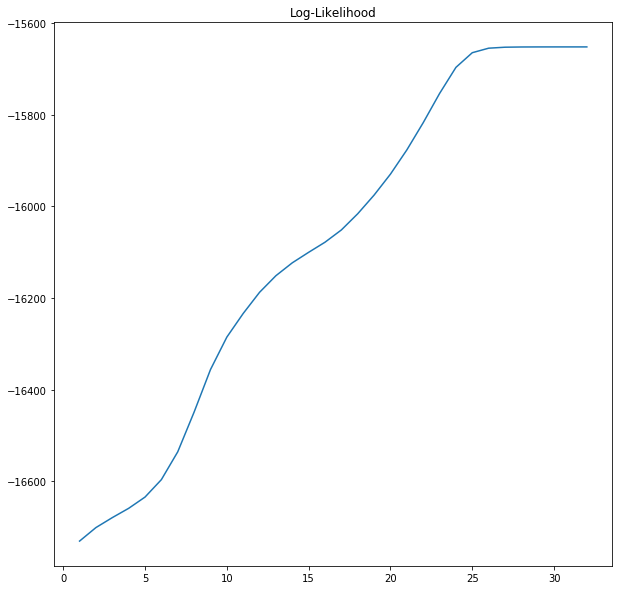

In [491]:
# This is part of the answre to Q1-b
# plotting the log-likelihood function versus the number of iteration

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111) 
ax.set_title('Log-Likelihood')
ax.plot(iterations[1:],log_likelihood[1:])
plt.show()

## Question 2c

### Mean Images

In [492]:
#print(V.shape)
#print(mu)
new_mu = (np.dot(mu,V.T))
#new_mu = new_mu.T
print(new_mu.shape)

(2, 784)


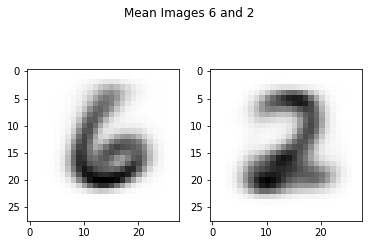

In [493]:
fig, (axis1, axis2) = plt.subplots(1, 2)

img1 = new_mu[0].reshape((28,28))
img2 = new_mu[1].reshape((28,28))


fig.suptitle('Mean Images 6 and 2')
axis1.imshow(np.rot90(np.fliplr(img1)), cmap="Greys") #source https://www.pythonpool.com/numpy-fliplr/
axis2.imshow(np.rot90(np.fliplr(img2)), cmap="Greys")

In [494]:
print(sigma[0].shape)
print(sigma[0])
print(sigma[1])

(4, 4)
[[ 3.18641782 -1.32533344 -0.32770642 -0.29552036]
 [-1.32533344  1.70270866  0.34091955  0.39374582]
 [-0.32770642  0.34091955  5.86521884  1.93494333]
 [-0.29552036  0.39374582  1.93494333  2.31931975]]
[[ 2.96667055  0.35714668  0.269059   -0.94441422]
 [ 0.35714668  1.55205828 -0.68879824  1.26979269]
 [ 0.269059   -0.68879824  1.78345622 -1.97860671]
 [-0.94441422  1.26979269 -1.97860671  4.77582833]]


### Covariance Matrix

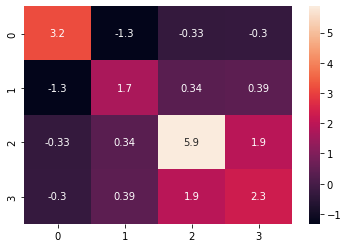

In [495]:
sns.heatmap(sigma[0],annot=True)

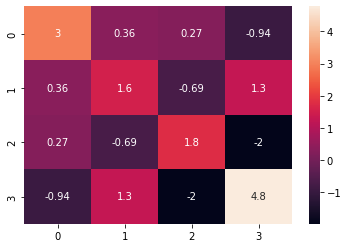

In [496]:
sns.heatmap(sigma[1],annot=True)

### Weights

In [497]:
print("Component 1: " + str(pi[0]))
print("Component 2: " + str(pi[1]))

Component 1: 0.5132003044162703
Component 2: 0.48679969558372965


## Question 2.d

In [498]:
#generate indices for max value of each image. 1 or 0
preds = np.argmax(tau,axis=1)
print(preds.sum())

975


In [499]:
#confirm length
len(preds)

1990

In [500]:
#Confirm length of labels
len(trueLabel)

1990

In [501]:
CM = metrics.confusion_matrix(preds,trueLabel)
report = metrics.classification_report(preds,trueLabel)

In [502]:
print(CM)

[[949  66]
 [  9 966]]


In [503]:
print(report)

              precision    recall  f1-score   support

           0       0.99      0.93      0.96      1015
           1       0.94      0.99      0.96       975

    accuracy                           0.96      1990
   macro avg       0.96      0.96      0.96      1990
weighted avg       0.96      0.96      0.96      1990



In [504]:
#use k-means package
kmeans = KMeans(n_clusters=2, random_state=1).fit(data)
k_preds   = kmeans.labels_

In [505]:
print(type(k_preds))

<class 'numpy.ndarray'>


In [506]:
k_preds_rev = np.where((k_preds==0)|(k_preds==1), k_preds^1, k_preds)
k_preds_rev.sum()

1044

In [507]:
CM = metrics.confusion_matrix(k_preds_rev,trueLabel)
report = metrics.classification_report(k_preds_rev,trueLabel)

In [508]:
print(CM)
print(report)

[[890  56]
 [ 68 976]]
              precision    recall  f1-score   support

           0       0.93      0.94      0.93       946
           1       0.95      0.93      0.94      1044

    accuracy                           0.94      1990
   macro avg       0.94      0.94      0.94      1990
weighted avg       0.94      0.94      0.94      1990

